# CSCE 670 :: Information Storage and Retrieval :: Spring 2020
## Spotlight : SparkNLP

#### Submitted by: Rizu Jain


### Yet another NLP Library? 
#####  (Well, There's something that others don't offer.)

44 distinct use cases across 17 industries! : The report https://tractica.omdia.com/newsroom/press-releases/natural-language-processing-is-a-key-engine-of-ai-market-growth-enabling-44-discrete-use-cases-across-17-industries/ depicts that NLP is one of the most pivotal engine that drives the AI market growth.

Be it building a chatbot, searching through a patent database, matching patients to clinical trials, grading customer service or sales calls or extracting facts from financial reports - we got to extract accurate information from free text.

- Spark NLP provides a singular solution for all the basic NLP tasks. The following table evidently shows that Spark NLP makes an attempt to ease the burden of text preprocessing. By providing pretrained pipelines, it also connects the dots between various steps of solving a data science problem.
    ![image.png](attachment:image.png "Title")            ( Source: https://twitter.com/JohnSnowLabs/status/1220024867095031808.)<br>
- Apache SparkML Library integrated in Spark NLP. The takeway is the in-memory distributed data processing engine. By having the data preprocessing in the pipeline alongwith NLP framework, a lot of comuting time gets saved. To read more about Apache SparkML, here is the link : http://homepages.cs.ncl.ac.uk/paolo.missier/doc/p56-zaharia.pdf<br>
- We know that a pre-trained language model can provide state-of-the-art results on a wide range of NLP tasks. By utilising this transfer learning, Spark NLP sets a stage for implementation of advanced algorithms.

##### Check this out for the use cases that Spark NLP is being deployed in : https://www.johnsnowlabs.com/nlp-case-studies/


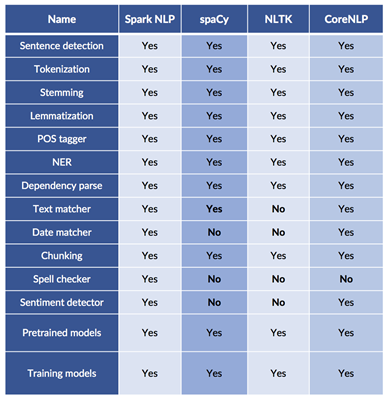

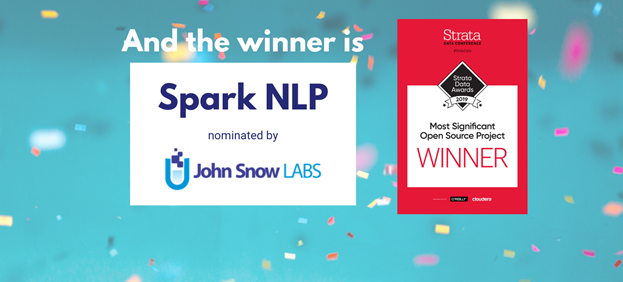

## Installation : Requirements & Setup

Python is a requirement (Python 3.3 or greater, or Python 2.7)

The following are setup guidelines using Anaconda distribution of packages.

- Install Apache Spark: install pyspark 2.4.4 using conda by running in your terminal:

        $ conda install pyspark=2.4.4
    
    
- Install Spark NLP Opensource as follow:

        $ conda install -c johnsnowlabs spark-nlp=2.4.2
      

##### To get started run the following code:

In [1]:
import sparknlp

# When this code works, we know we have successfully started a SparkNLP session!
sparknlp.start()

If the above code doesn't run, lets dig deeper into our installation issues:
- This link will help us check our setup: https://nlp.johnsnowlabs.com/docs/en/install

- For Windows OS, we might need to add some efforts. Check this post: https://medium.com/@naomi.fridman/install-pyspark-to-run-on-jupyter-notebook-on-windows-4ec2009de21f
- For MacOS, this might help: https://medium.com/luckspark/installing-spark-2-3-0-on-macos-high-sierra-276a127b8b85

# Information Retreival using Spark NLP
## A. Revisiting the basics. This time with a new tool

#### Now we see how we can handle the tasks of indexing, ranking and retreival using Spark NLP

In [2]:
import os

from pyspark.sql.types import *
from pyspark.sql.functions import collect_set
from pyspark.sql import Row
from pyspark.ml import Pipeline

import sparknlp
from sparknlp import DocumentAssembler, Finisher

spark = sparknlp.start()

#### Load the data set into spark

In [3]:
path = os.path.join('newsgroups', '*')
texts = spark.sparkContext.wholeTextFiles(path)

schema = StructType([
    StructField('path', StringType()),
    StructField('text', StringType()),
])

texts = spark.createDataFrame(texts, schema=schema).persist()

#### How to access data and its index in Spark [!!RDD ALERT]

In [4]:
rows_w_indexed = texts.rdd.zipWithIndex()
(path, text), i = rows_w_indexed.first()

print(i)
print(path)
print(text[:100])

0
file:/D:/tamu_gdrive/670/CSCE670_Information-Retrieval/Spotlight/RizuJain_SparkNLP_March05/newsgroups/alt.atheism.txt
From: mathew <mathew@mantis.co.uk>
Subject: Alt.Atheism FAQ: Atheist Resources

Archive-name: atheis


### Creating the index
#### Create a DataFrame and add index to the rows

In [5]:
indexed = rows_w_indexed.map(
    lambda row_index: Row(
        index=row_index[1], 
        **row_index[0].asDict())
)
(i, path, text) = indexed.first()

In [6]:
indexed_schema = schema.add(StructField('index', IntegerType()))

indexed = spark.createDataFrame(indexed, schema=indexed_schema)\
    .persist()

In [7]:
indexed.limit(10).toPandas()

path  \
0  file:/D:/tamu_gdrive/670/CSCE670_Information-R...   
1  file:/D:/tamu_gdrive/670/CSCE670_Information-R...   
2  file:/D:/tamu_gdrive/670/CSCE670_Information-R...   
3  file:/D:/tamu_gdrive/670/CSCE670_Information-R...   
4  file:/D:/tamu_gdrive/670/CSCE670_Information-R...   
5  file:/D:/tamu_gdrive/670/CSCE670_Information-R...   
6  file:/D:/tamu_gdrive/670/CSCE670_Information-R...   
7  file:/D:/tamu_gdrive/670/CSCE670_Information-R...   
8  file:/D:/tamu_gdrive/670/CSCE670_Information-R...   
9  file:/D:/tamu_gdrive/670/CSCE670_Information-R...   

                                                text  index  
0  From: mathew <mathew@mantis.co.uk>\nSubject: A...      0  
1  From: lipman@oasys.dt.navy.mil (Robert Lipman)...      1  
2  Newsgroup: comp.os.ms-windows.misc\ndocument_i...      2  
3  Newsgroup: comp.sys.ibm.pc.hardware\ndocument_...      3  
4  Newsgroup: comp.sys.mac.hardware\ndocument_id:...      4  
5  Newsgroup: comp.windows.x\ndocument_id: 64830\...      5  
6  newsgroup,document_id\ntalk.religion.misc,8275...      6  
7  Newsgroup: misc.forsale\ndocument_id: 70337\nF...      7  
8  Newsgroup: rec.autos\ndocument_id: 101551\nFro...      8  
9  Newsgroup: rec.motorcycles\ndocument_id: 10172...      9

Note: The original data just contains the 3 columns. 'path' and 'text' is how we parsed the data and 'index' was added later.

## The fun begins....
#### [The reason why Spark NLP is an incredibly useful tool. ]
### For processing of the text we create a pipeline with processing blocks using the following steps
#### 1. Select the process and find either the pretrained module or a generic module from SparkNLP's exhaustive list of modules<br> 2. Set the input column for this process block<br>3. Set the output column for this process block


In [8]:
import sparknlp
from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *
from sparknlp.pretrained import PretrainedPipeline

In [9]:

assembler = DocumentAssembler()\
    .setInputCol('text')\
    .setOutputCol('document')

tokenizer = Tokenizer()\
    .setInputCols(['document'])\
    .setOutputCol('token')

lemmatizer = LemmatizerModel.pretrained()\
    .setInputCols(['token'])\
    .setOutputCol('lemma')

normalizer = Normalizer()\
    .setInputCols(['lemma'])\
    .setOutputCol('normalized')\
    .setLowercase(True)

finisher = Finisher()\
    .setInputCols(['normalized'])\
    .setOutputCols(['normalized'])\
    .setOutputAsArray(True)


lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


#### Once all the processing blocks are initialized, create the pipeline

In [10]:
pipeline = Pipeline().setStages([
    assembler, tokenizer, 
    lemmatizer, normalizer, finisher
]).fit(indexed)

#### All that remains is to use this pipeline to tranform our data

In [11]:
indexed_w_tokens = pipeline.transform(indexed)

In [12]:
indexed_w_tokens.limit(10).toPandas()

path  \
0  file:/D:/tamu_gdrive/670/CSCE670_Information-R...   
1  file:/D:/tamu_gdrive/670/CSCE670_Information-R...   
2  file:/D:/tamu_gdrive/670/CSCE670_Information-R...   
3  file:/D:/tamu_gdrive/670/CSCE670_Information-R...   
4  file:/D:/tamu_gdrive/670/CSCE670_Information-R...   
5  file:/D:/tamu_gdrive/670/CSCE670_Information-R...   
6  file:/D:/tamu_gdrive/670/CSCE670_Information-R...   
7  file:/D:/tamu_gdrive/670/CSCE670_Information-R...   
8  file:/D:/tamu_gdrive/670/CSCE670_Information-R...   
9  file:/D:/tamu_gdrive/670/CSCE670_Information-R...   

                                                text  index  \
0  From: mathew <mathew@mantis.co.uk>\nSubject: A...      0   
1  From: lipman@oasys.dt.navy.mil (Robert Lipman)...      1   
2  Newsgroup: comp.os.ms-windows.misc\ndocument_i...      2   
3  Newsgroup: comp.sys.ibm.pc.hardware\ndocument_...      3   
4  Newsgroup: comp.sys.mac.hardware\ndocument_id:...      4   
5  Newsgroup: comp.windows.x\ndocument_id: 64830\...      5   
6  newsgroup,document_id\ntalk.religion.misc,8275...      6   
7  Newsgroup: misc.forsale\ndocument_id: 70337\nF...      7   
8  Newsgroup: rec.autos\ndocument_id: 101551\nFro...      8   
9  Newsgroup: rec.motorcycles\ndocument_id: 10172...      9   

                                          normalized  
0  [from, mathew, mathewmantiscouk, subject, alta...  
1  [from, lipmanoasysdtnavymil, robert, lipman, s...  
2  [newsgroup, composmswindowsmisc, documentid, f...  
3  [newsgroup, compsysibmpchardware, documentid, ...  
4  [newsgroup, compsysmachardware, documentid, fr...  
5  [newsgroup, compwindowsx, documentid, from, ch...  
6  [newsgroupdocumentid, talkreligionmisc, talkre...  
7  [newsgroup, miscforsale, documentid, from, ked...  
8  [newsgroup, recautos, documentid, from, cscsbr...  
9  [newsgroup, recmotorcycles, documentid, subjec...

#### Piece of cake!

In [13]:
index = indexed_w_tokens.select('index', 'path', 'text').toPandas()
index = index.set_index('index')

### Inverted index
#### SQL to generate inverted index efficiently

In [14]:
inverted_index = indexed_w_tokens\
    .selectExpr('index', 'explode(normalized) AS term')\
    .distinct()\
    .groupBy('term').agg(collect_set('index').alias('documents'))\
    .persist()

In [15]:
inverted_index.show(10)

+--------------------+-------------------+
|                term|          documents|
+--------------------+-------------------+
|           +religion|                [0]|
|              abbrev|               [10]|
|accgsgvaxbhofstraedu|               [11]|
|        accumulation|[12, 1, 16, 13, 14]|
|             acidity|               [19]|
|      ackerwgwaiicom|                [5]|
| adamsrnorwichbitnet|                [3]|
|           addrphone|               [12]|
|          adventists|       [16, 20, 17]|
|        aegeetilburg|                [1]|
+--------------------+-------------------+
only showing top 10 rows



In [16]:
inverted_index = {
    term: set(docs) 
    for term, docs in inverted_index.collect()
}

### Boolean Retrieval

In [17]:
acc_docs = inverted_index['accumulation']
print('docs', ('{}, ' * 5).format(*list(acc_docs)[:5]))
print('number of docs', len(acc_docs))

docs 1, 12, 13, 14, 16, 
number of docs 5


In [18]:
lang_docs = inverted_index['language']
print('docs', ('{}, ' * 10).format(*list(lang_docs)[:10]), '...')
print('number of docs', len(lang_docs))

docs 0, 1, 2, 3, 4, 5, 7, 8, 9, 10,  ...
number of docs 20


#### 'AND' & 'OR'

In [19]:
filter_set = list(lang_docs | acc_docs)
print('number of docs in filter set', len(filter_set))

number of docs in filter set 20


In [20]:
intersection = list(lang_docs & acc_docs)
print('number of docs in intersection set', len(intersection))

number of docs in intersection set 5


## B. Text Matching

#### Spark NLP also provide ability to do the end-to-end query searching, right from document parsing, to query matching in a single pipeline.
#### Demonstrating query matching on the data used in first Homework

In [21]:
documentAssembler_tm = DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")

sentenceDetector_tm = SentenceDetector()\
  .setInputCols(["document"])\
  .setOutputCol("sentence")

tokenizer_tm = Tokenizer()\
  .setInputCols(["document"])\
  .setOutputCol("token")

extractor_tm = TextMatcher()\
  .setEntities("entities.txt")\
  .setInputCols(["token", "sentence"])\
  .setOutputCol("entites")

finisher_tm = Finisher() \
    .setInputCols(["entites"]) \
    .setIncludeMetadata(False) \
    .setCleanAnnotations(True)

pipeline = Pipeline(
    stages = [
    documentAssembler_tm,
    sentenceDetector_tm,
    tokenizer_tm,
    extractor_tm,
    finisher_tm
  ])


#### Created parquet data file from the .txt file. Present in the package submitted.

In [22]:
data = spark. \
        read. \
        parquet("hw1_data_1.parquet"). \
        limit(1000).cache()
data.show(10)

+------------------+---+--------------------+
|          keywords| id|                text|
+------------------+---+--------------------+
|bottom-up approach|  0|estimates of dura...|
|bottom-up approach|  1|pattern from proc...|
|bottom-up approach|  2|  normalization; 3nf|
|bottom-up approach|  3|client factor sta...|
|bottom-up approach|  4|approach for dyna...|
|bottom-up approach|  5|piecing together ...|
|bottom-up approach|  6|piecing together ...|
|bottom-up approach|  7|begins by looking...|
|bottom-up approach|  8|begins at the lev...|
|bottom-up approach|  9|often the most in...|
+------------------+---+--------------------+
only showing top 10 rows



#### Calling fit starts the actual processing in the pipeline. The tokenization and sentence parsing will happen at this stage.

In [23]:
model = pipeline.fit(data)

#### Now let us match the entities. They were added to the extractor module in the pipeline. "entities.txt" contain the queries that are used for  retrieving sentences. Attached in the package submitted.

In [24]:
extracted = model.transform(data)

# filter rows with extracted text
extracted\
.filter("size(finished_entites) != 0") \
.show(20)

+--------------------+---+--------------------+--------------------+
|            keywords| id|                text|    finished_entites|
+--------------------+---+--------------------+--------------------+
|database manageme...|582|a software packag...|         [retrieval]|
|database manageme...|607|software used to ...|         [retrieval]|
|database manageme...|654|dbms allows users...|[relational datab...|
|database manageme...|673|software that han...|         [retrieval]|
|    relational model|750|all relational da...|[relational datab...|
|    relational model|759|conceptual simpli...|[relational datab...|
|    relational model|788|mimics the struct...|[relational datab...|
|    relational model|802|structured data o...|[relational datab...|
|    relational model|804|a relational data...|[relational datab...|
+--------------------+---+--------------------+--------------------+



#### Another feature: Save the model. Reload and run whenever needed. Just one line of code to accomplish this.

In [25]:
model.write().overwrite().save("./extractor_model")

In [26]:
from pyspark.ml import  Pipeline

sameModel = PipelineModel.read().load("./extractor_model")

sameModel.transform(data) \
.filter("size(finished_entites) != 0") \
.show()

+--------------------+---+--------------------+--------------------+
|            keywords| id|                text|    finished_entites|
+--------------------+---+--------------------+--------------------+
|database manageme...|582|a software packag...|         [retrieval]|
|database manageme...|607|software used to ...|         [retrieval]|
|database manageme...|654|dbms allows users...|[relational datab...|
|database manageme...|673|software that han...|         [retrieval]|
|    relational model|750|all relational da...|[relational datab...|
|    relational model|759|conceptual simpli...|[relational datab...|
|    relational model|788|mimics the struct...|[relational datab...|
|    relational model|802|structured data o...|[relational datab...|
|    relational model|804|a relational data...|[relational datab...|
+--------------------+---+--------------------+--------------------+



### Spark NLP has many more features to explore. Its a rich library loved by the industry.